<a href="https://colab.research.google.com/github/igormatt0s/Fruits-Vegetables-Image-Recognition/blob/main/Fruits_and_Vegetables_Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconhecimento de Frutas e Vegetais com Abordagem com Redes Neurais Convolucionais (CNNs)

O dataset coletado do Kaggle abrange imagens de diversas frutas e vegetais, fornecendo uma coleção diversificada para tarefas de reconhecimento de imagens. Os alimentos incluídos são:

- Frutas: Banana, Maçã, Pera, Uva, Laranja, Kiwi, Melancia, Romã, Abacaxi, Manga
- Vegetais: Pepino, Cenoura, Pimentão, Cebola, Batata, Limão, Tomate, Rabanete, Beterraba, Repolho, Alface, Espinafre, Soja, Couve-flor, Pimentão, Pimenta, Nabo, Milho, Milho-doce, Batata-doce, Páprica, Jalapeño, Gengibre, Alho, Ervilha, Berinjela

Organizado em três pastas principais:

- Train: Contém 100 imagens por categoria.
- Test: Contém 10 imagens por categoria.
- Validation: Contém 10 imagens por categoria.

Cada uma dessas pastas é subdividida em pastas específicas para cada tipo de fruta e vegetal, contendo as respectivas imagens.

## Citação

Kritik Seth, "Fruits and Vegetables Image Recognition Dataset," Kaggle 2020 [https://www.kaggle.com/kritikseth/fruit-and-vegetable-image-recognition]

## 1- Importação das Bibliotecas

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks, regularizers

In [2]:
from google.colab import drive
if not os.path.ismount('/content/drive'):
    print("Montando o Google Drive...")
    drive.mount('/content/drive')

Montando o Google Drive...
Mounted at /content/drive


## 2- Carregamento do Dataset

In [3]:
# Caminhos
base_dir = "/content/drive/MyDrive/dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

# Parâmetros
img_size = 224
batch_size = 32
num_classes = 36

## 3- Pré-processamento

In [4]:
# Data augmentation com preprocess_input específico do ResNet50
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    # vertical_flip e horizontal_flip permitem que as imagens sejam viradas vertical e horizontalmente, o que ajuda a criar mais variação nos dados de treino.
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1
)

# Apenas normalização para validação e teste
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Carrega as imagens do diretório especificado e aplica o gerador de imagens
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size), # target_size redimensiona as imagens para o tamanho especificado (altura, largura).
    batch_size=batch_size, # batch_size define o número de imagens a serem carregadas por vez.
    class_mode='categorical', # class_mode='categorical' significa que as classes serão representadas por vetores one-hot.
    shuffle=True # shuffle=True embaralha as imagens a cada época para evitar dependências entre as amostras.
)

# Carrega as imagens do diretório especificado e aplica o gerador de imagens
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Carrega as imagens do diretório especificado e aplica o gerador de imagens
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # shuffle=False garante que a ordem dos rótulos verdadeiros corresponda à dos rótulos previstos.
)

Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.
Found 359 images belonging to 36 classes.


## 4- Modelo Pré-treinado

In [5]:
# Carrega o modelo ResNet50  pré-treinado com pesos do ImageNet.
# include_top=False significa que a camada final de classificação (top) não é incluída, permitindo que o modelo seja usado para extração de características ou para ser adaptado a uma nova tarefa de classificação.
# imagens de entrada: 224x224 pixels com 3 canais (RGB).
modelo_base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Congela inicialmente todas as camadas, impedindo que os pesos do ResNet50 sejam atualizados durante o treinamento.
modelo_base.trainable = False

# Define a camada de entrada que aceita imagens com a forma especificada (224x224x3).
camada_entrada = Input(shape=(img_size, img_size, 3))

# Passa as imagens de entrada através do modelo base, gerando uma saída de características.
x = modelo_base(camada_entrada, training=False)

# Aplica Batch Normalization, que normaliza a ativação da camada anterior.
# Isso ajuda a acelerar o treinamento e a estabilidade do modelo.
x = BatchNormalization()(x)

# Aplica o GlobalAveragePooling2D, que reduz a dimensão espacial (altura e largura) da saída para um vetor, calculando a média dos valores em cada canal. Isso resulta em uma representação compacta da imagem, mantendo informações relevantes.
x = GlobalAveragePooling2D()(x)

# Adiciona uma camada densa totalmente conectada com 256 neurônios.
# Os parâmetros de regularização ajudam a penalizar pesos grandes, promovendo um modelo mais simples:
# - kernel_regularizer=L2: Aplica regularização L2 nos pesos da camada.
# A ativação 'relu' é usada para introduzir não-linearidade.
x = Dense(256, kernel_regularizer=regularizers.L2(0.001), activation='relu')(x)

# Adiciona uma camada de Dropout com taxa de 30%, que desativa aleatoriamente 30% dos neurônios durante o treinamento, ajudando a prevenir overfitting, onde o modelo se ajusta excessivamente aos dados de treinamento.
x = Dropout(0.3)(x)

# Adiciona uma camada densa totalmente conectada com 128 neurônios.
x = Dense(128, activation='relu')(x)

# Adiciona a camada de saída com 'num_classes' neurônios, onde 'num_classes' é o número de classes para a tarefa de classificação.
# A ativação 'softmax' é usada para converter as saídas em probabilidades de cada classe.
camada_saida = Dense(num_classes, activation='softmax')(x)

# Cria o modelo final, conectando a camada de entrada à camada de saída.
modelo = Model(camada_entrada, camada_saida)

# Exibe um resumo do modelo, mostrando as camadas e o número de parâmetros treináveis.
modelo.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,157,988 (92.16 MB)

 Trainable params: 566,180 (2.16 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

## 5- Compilação do Modelo

In [6]:
# define o otimizar para o cálculo de ajuste dos parâmetros/pesos do modelo
# define a função para o cálculo do loss (erro entre o valor previsto e o esperado)
modelo.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

## 6- Treinamento do Modelo

In [7]:
# Callbacks
caminho_checkpoints = '/content/melhor_modelo_resnet50.weights.h5'
caminho_log = '/content/historico_resnet50.csv'

# Criação do callback para pontos de verificação
cp = callbacks.ModelCheckpoint(filepath=caminho_checkpoints, save_weights_only=True, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
# Criação do callback para log dos valores de acurácia e loss a cada época
csv_logger = callbacks.CSVLogger(caminho_log)
# Reduz a tx de aprendizado se a mudança for menor do que o factor em val_los
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
# Para o treinamento se val_loss parar de diminuir por 3 épocas consecutivas
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

callback_list = [cp, csv_logger, lr_scheduler, early_stop]

# Treinamento inicial com camadas congeladas
history_initial = modelo.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=callback_list
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 2/98 ━━━━━━━━━━━━━━━━━━━━ 7:29 5s/step - accuracy: 0.0312 - loss: 4.0982  

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.0696 - loss: 3.9708 
Epoch 1: val_accuracy improved from -inf to 0.49288, saving model to /content/melhor_modelo_resnet50.weights.h5
98/98 ━━━━━━━━━━━━━━━━━━━━ 1451s 15s/step - accuracy: 0.0702 - loss: 3.9692 - val_accuracy: 0.4929 - val_loss: 3.2015 - learning_rate: 1.0000e-04
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3837 - loss: 3.2796
Epoch 2: val_accuracy improved from 0.49288 to 0.72934, saving model to /content/melhor_modelo_resnet50.weights.h5
98/98 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.3842 - loss: 3.2780 - val_accuracy: 0.7293 - val_loss: 2.2706 - learning_rate: 1.0000e-04
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5595 - loss: 2.5605
Epoch 3: val_accuracy improved from 0.72934 to 0.78632, saving model to /content/melhor_modelo_resnet50.weights.h5
98/98 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.5597 - loss: 2.5589 - val_accuracy: 0.7863 - val_loss: 1.5481 - learning_rat

In [8]:
# Fine-tuning: descongela as últimas 60 camadas
for layer in modelo_base.layers[-60:]:
    layer.trainable = True

# Recompila com taxa de aprendizado menor
modelo.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Treinamento final com fine-tuning
history_finetune = modelo.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callback_list
)

# Carrega os melhores pesos
modelo.load_weights(caminho_checkpoints)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7204 - loss: 1.5906
Epoch 1: val_accuracy improved from 0.87179 to 0.89459, saving model to /content/melhor_modelo_resnet50.weights.h5
98/98 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.7206 - loss: 1.5902 - val_accuracy: 0.8946 - val_loss: 0.8785 - learning_rate: 1.0000e-05
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7666 - loss: 1.4315
Epoch 2: val_accuracy did not improve from 0.89459
98/98 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.7666 - loss: 1.4311 - val_accuracy: 0.8917 - val_loss: 0.8269 - learning_rate: 1.0000e-05
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7941 - loss: 1.2645
Epoch 3: val_accuracy improved from 0.89459 to 0.90313, saving model to /content/melhor_modelo_resnet50.weights.h5
98/98 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.7940 - loss: 1.2647 - val_accuracy: 0.9031 - val_loss: 0.7804 - learning_rate: 1.0000e-05
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 

## 7- Salva o Modelo

In [9]:
modelo.save('/content/ResNet50_modelo.keras')
print(f'\nO modelo treinado foi salvo na pasta /content/ResNet50_modelo.keras\n')


O modelo treinado foi salvo na pasta /content/ResNet50_modelo.keras



## 8- Plota o Histórico

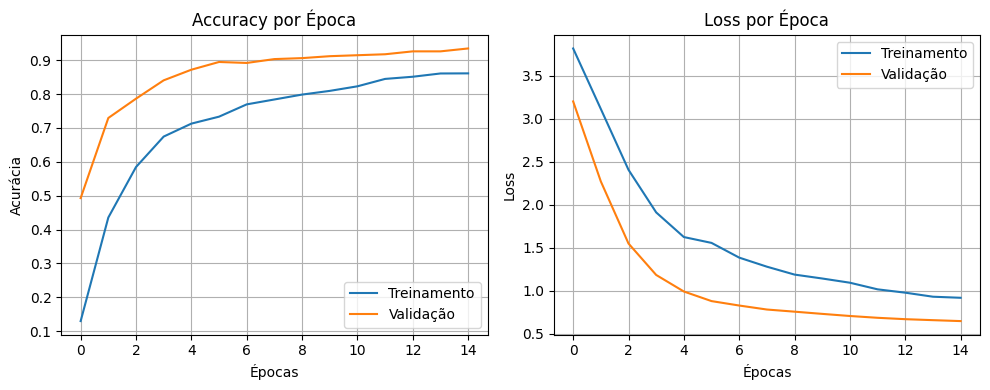

In [10]:
# Junta os dois históricos: history_initial e history_finetune
def combinar_historia(hist1, hist2):
    combinado = {}
    for key in hist1.history.keys():
        combinado[key] = hist1.history[key] + hist2.history[key]
    return combinado

# Combine os históricos
historico_total = combinar_historia(history_initial, history_finetune)

# Plotando acurácia e perda
plt.figure(figsize=(10, 4))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(historico_total['accuracy'], label='Treinamento')
plt.plot(historico_total['val_accuracy'], label='Validação')
plt.title('Accuracy por Época')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

# Perda
plt.subplot(1, 2, 2)
plt.plot(historico_total['loss'], label='Treinamento')
plt.plot(historico_total['val_loss'], label='Validação')
plt.title('Loss por Época')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 9- Testar o Modelo Treinado

In [11]:
modelo_treinado = load_model('/content/ResNet50_modelo.keras')

In [12]:
# Gera previsões usando o modelo
previsoes = modelo_treinado.predict(test_generator, verbose=2)
# Converte as previsões em rótulos. Cada linha da previsão contém probabilidades para cada classe, e np.argmax() retorna o índice da classe com a maior probabilidade.
rotulos_previstos = np.argmax(previsoes, axis=1)

12/12 - 120s - 10s/step


In [13]:
# Avaliação final no conjunto de teste
loss, acc = modelo.evaluate(test_generator)
print(f"\n✅ Acurácia final no conjunto de teste: {acc:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9038 - loss: 0.7158

✅ Acurácia final no conjunto de teste: 0.9359


## 10- Plota e Salva os Resultados do Modelo


Matriz salva na pasta: /content/resultados_avaliacao/



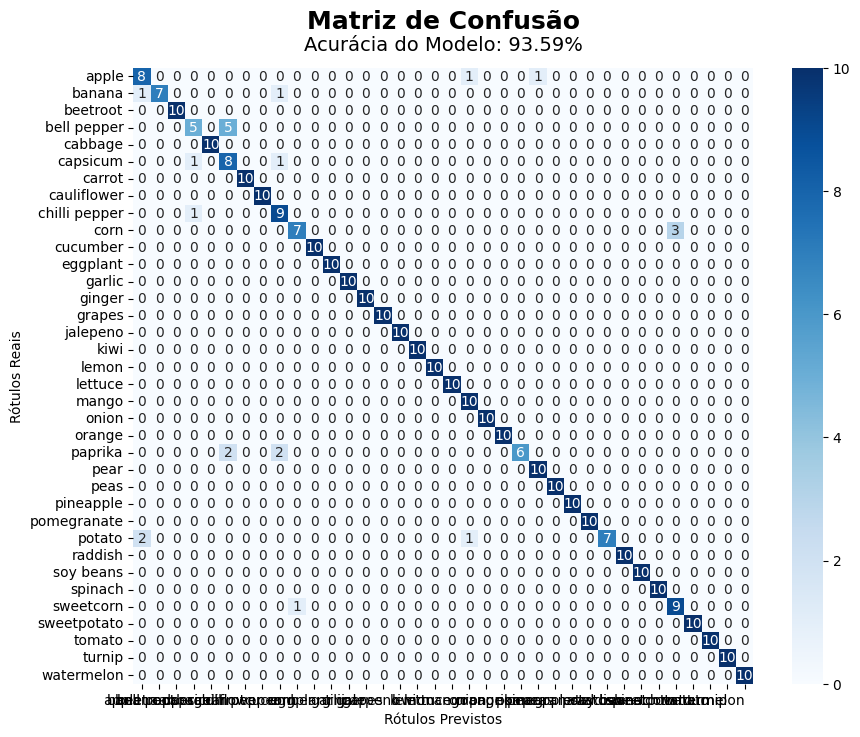

In [14]:
# Calcula a matriz de confusão
conf_matrix = confusion_matrix(test_generator.classes, rotulos_previstos)
# Calcula a acurácia do modelo em percentual
acuracia = accuracy_score(test_generator.classes, rotulos_previstos) * 100

# Gera a figura da matriz de confusão usando o pacote seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

# Nomes das classes
nomes_das_classes = list(test_generator.class_indices.keys())

# Diretório para salvar os resultados
caminho_resultados = '/content/resultados_avaliacao/'

# Adiciona os nomes das classes, rótulos, título, subtítulo e salva a figura da matriz de confusão
plt.xticks(np.arange(len(nomes_das_classes)) + 0.5, nomes_das_classes, rotation=0, ha='right')
plt.yticks(np.arange(len(nomes_das_classes)) + 0.5, nomes_das_classes, rotation=0, va='center')
plt.xlabel('Rótulos Previstos')
plt.ylabel('Rótulos Reais')
plt.title('Matriz de Confusão', fontsize=18, weight='bold', x=0.5, y=1.05)
plt.suptitle(f'Acurácia do Modelo: {acuracia:.2f}%', fontsize=14, x=0.435, y=0.92)

os.makedirs(caminho_resultados, exist_ok=True)
plt.savefig(os.path.join(caminho_resultados, 'Matriz_Confusao.png'), dpi=300)
print(f'\nMatriz salva na pasta: {caminho_resultados}\n')
plt.show()


Métrica salva na pasta: /content/resultados_avaliacao/



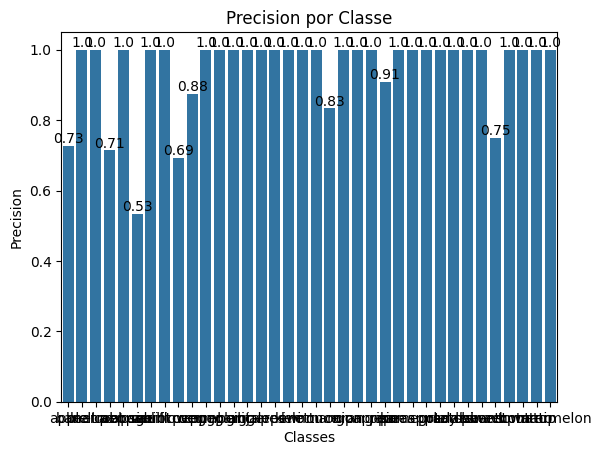


Métrica salva na pasta: /content/resultados_avaliacao/



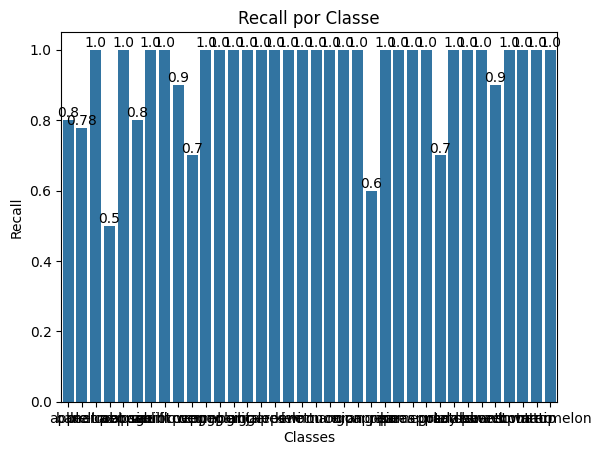


Métrica salva na pasta: /content/resultados_avaliacao/



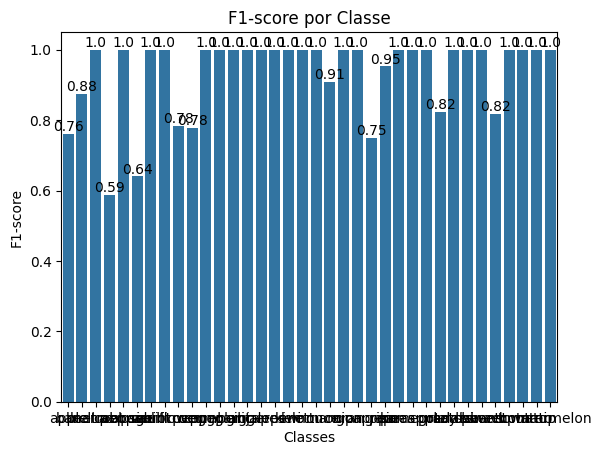

In [15]:
# Função para criar e salvar um gráfico para uma métrica escolhida
def plot_metrica(rotulos_verdadeiros, rotulos_previstos, nome_metrica, nomes_das_classes, caminho_resultados):
    # Obtém um relatório de classificação da scikit-learn como um dicionário
    report_dict = classification_report(rotulos_verdadeiros, rotulos_previstos, target_names=nomes_das_classes, output_dict=True)
    # cria um dicionário para a métrica de interesse (precision, recall ou f1-score)
    metric_data = {
        # chave-valor = nome da classe : valor  da métrica
        class_name: metrics[nome_metrica]
        for class_name, metrics in report_dict.items()
        # apenas as classes da lista class_names serão incluídas no dicionário metric_data.
        if class_name in nomes_das_classes
    }

    sns.barplot(x=list(metric_data.keys()), y=list(metric_data.values()))
    plt.xlabel('Classes')
    plt.ylabel(nome_metrica.capitalize())
    plt.title(f'{nome_metrica.capitalize()} por Classe')
    plt.xticks(rotation=0)

    # Adiciona rótulos de texto para os valores máximos em cada barra
    for index, value in enumerate(metric_data.values()):
        plt.text(index, value, str(round(value, 2)), ha='center', va='bottom')

    os.makedirs(caminho_resultados, exist_ok=True)
    # Salva a figura
    plt.savefig(os.path.join(caminho_resultados, f'{nome_metrica}.png'), dpi=300)
    print(f'\nMétrica salva na pasta: {caminho_resultados}\n')
    # Limpa a figura
    plt.show()

# Gera e salva métricas por classe
for metrica in ['precision', 'recall', 'f1-score']:
    plot_metrica(test_generator.classes, rotulos_previstos, metrica, nomes_das_classes, caminho_resultados)